#Group 1

Fabio Ceruti - Fabio Martino - Alex Lucchini - Jacopo Biggiogera

This notebook contains the code to identify clusters of families by using bboxes only.

In [ ]:
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.image import resize_with_pad, ResizeMethod
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from random import shuffle
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tqdm import tqdm
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

#Loading of the model to extract the features and sampling of the data

This subsection loads the ResNet model and prepares data to be passed for clusters identification.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.models import Model

base_model = ResNet50(weights='imagenet')  # Read the ImageNet pre-trained ResNet50 model.
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)  # We use the output from the 'avg_pool' layer.

def extract_feature(model, img):
    # This function takes a RGB image, then it returns a feature vector.
    x = np.array(tf.image.resize(img, (224, 224)))  # Resize to 224x224 since the ResNet50 takes this size as an input.
    x = np.float32(x)  # Convert from uint8 to float32
    x = np.expand_dims(x, axis=0)  
    x = preprocess_input(x)  # Subtract the average value of ImagNet for adequating your image to the format the model requires
    feature = model.predict(x, verbose = 0)[0]  # Extract a feature.
    feature /= np.linalg.norm(feature)  # Normalize the feature.
    return feature

102967424/102967424 [==============================] - 5s 0us/step


In [ ]:
no_context = pd.read_csv('/content/drive/MyDrive/data_for_bbcontent_model.csv')
no_context.head()

,path,species,label
0,Animals_bbcontent/Sciurus carolinensis/2d82dcf...,Sciurus carolinensis,9
1,Animals_bbcontent/Sciurus carolinensis/3286790...,Sciurus carolinensis,9
2,Animals_bbcontent/Sciurus carolinensis/c7b1366...,Sciurus carolinensis,9
3,Animals_bbcontent/Sciurus carolinensis/eb0edba...,Sciurus carolinensis,9
4,Animals_bbcontent/Sciurus carolinensis/de71bde...,Sciurus carolinensis,9


In [ ]:
no_context = pd.read_csv('/content/drive/MyDrive/data_for_bbcontent_model.csv')
for i in tqdm(range(len(no_context['path']))):
  no_context.loc[i, 'path'] = '/content/drive/MyDrive/Animals_bbcontent/' + no_context.loc[i, 'path']

100%|██████████| 14941/14941 [00:10<00:00, 1442.14it/s]


In [ ]:
#Generation of families labels
reptilia = ['Anolis carolinensis', 'Chelydra serpentina', 'Trachemys scripta elegans']
mammalia = ['Canis latrans', 'Procyon lotor', 'Sciurus carolinensis']
aves = ['Pandion haliaetus', 'Picoides pubescens', 'Spinus tristis']
insecta = ['Harmonia axyridis', 'Junonia coenia', 'Pachydiplax longipennis']
species = reptilia + mammalia + aves + insecta

family = dict()
for i in range(len(species)):
  if species[i] in reptilia:
    family[species[i]] = 'reptilia'
  elif species[i] in mammalia:
    family[species[i]] = 'mammalia'
  elif species[i] in aves:
    family[species[i]] = 'aves'
  elif species[i] in insecta:
    family[species[i]] = 'insecta'

for i in range(len(no_context['path'])):
  no_context.loc[i, 'family'] = family[no_context.loc[i, 'path'].split('/')[-2]]

no_context.loc[no_context['family'] == 'mammalia', 'family_label'] = 0
no_context.loc[no_context['family'] == 'aves', 'family_label'] = 1
no_context.loc[no_context['family'] == 'reptilia', 'family_label'] = 2
no_context.loc[no_context['family'] == 'insecta', 'family_label'] = 3

In [ ]:
def path_sampler(df,label_column, column_to_sample, n_per_group = 2, replace = False, seed = 8):
    '''This functon allows to select a subset of the data by saving paths to each observation
    Input: df with all the paths, 
    name of column with lables, 
    name of column with paths, 
    desired observation numbers per group
    
    Returns: df with selected subsample'''
    
    np.random.seed(seed)
    p_samp = []
    lab_samp = []
    for i in set(df[label_column]):
        selected = np.array(df[df[label_column]==i][column_to_sample])
        sample = np.random.choice(selected, size = n_per_group, replace = replace)
        p_samp+=list(sample)
        lab_samp += [i]*n_per_group
    return pd.DataFrame({column_to_sample:p_samp, label_column:lab_samp})

In [ ]:
#running path sampler to select 200 images per class 
#(=800 pictures that should be enough to see emergence of clusters)

for_clustering = path_sampler(no_context, 'family_label', 'path', n_per_group = 200)

#Reading selected paths as arrays for clustering
arrays_clust = [np.array(PIL.Image.open(i)) for i in tqdm(list(for_clustering['path']))]

100%|██████████| 800/800 [09:18<00:00,  1.43it/s]


#Extraction of the features and clustering

This section applies clustering to the samples of pictures selected from each species.

In [ ]:
#Extracting features from the model
from matplotlib.image import imread
np.random.seed(4)
features = []
labels = []
for i in tqdm(range(len(arrays_clust))):
    try:
        features.append(extract_feature(model, arrays_clust[i]))
        labels.append(for_clustering.loc[i, 'family_label'])

    except:
        PIL.Image.fromarray(arrays_clust[i])
features = np.array(features)

100%|██████████| 800/800 [00:58<00:00, 13.78it/s]


In [ ]:
#Dimensionality reduction using tsne
from sklearn.manifold import TSNE
np.random.seed(4)

tsne = TSNE(n_components=2)
twod_tsne = tsne.fit_transform(features) 

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


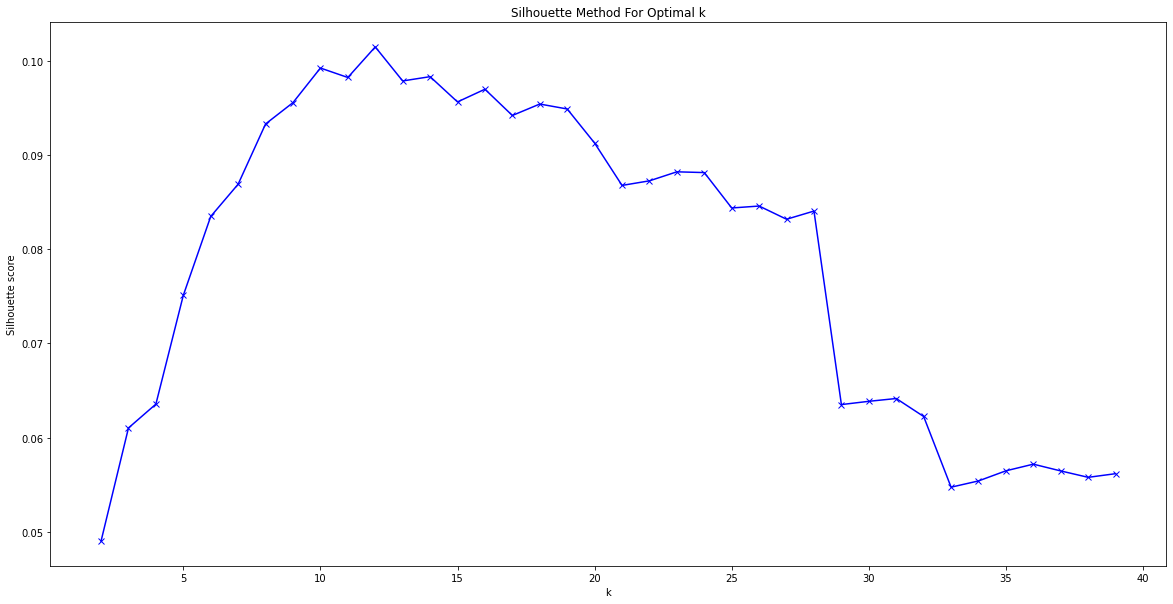

In [ ]:
#Using silouhette score to find optimal cluster numbers
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering


silhouettes = []

K = range(2, 40)

for c in K:
    agg_clustering = AgglomerativeClustering(n_clusters=c)
    agg_cluster_ids = agg_clustering.fit_predict(features)
    score = silhouette_score(features, agg_cluster_ids)
    silhouettes.append(score)
    
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [ ]:
#Clustering with optimised number of clusters
from sklearn.cluster import KMeans
n_clusters = 12 #Point at which silhoutette score maximises and thus cluster are most well defined
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(features)

In [ ]:
#Plotting example images from each cluster
import warnings
warnings.filterwarnings("ignore")
for k in range(n_clusters):
    print("Cluster id: k={}".format(k))
    img_ids = [img_id for img_id, cluster_id in enumerate(kmeans.labels_) if cluster_id == k]

    cols = 10
    img_ids = img_ids[0:cols] if cols < len(img_ids) else img_ids # Let's see the top 10 results
    
    # Visualize images assigned to this cluster
    imgs = np.array(arrays_clust)[img_ids]
    plt.figure(figsize=(20, 5))
    for i, img in enumerate(imgs):
        plt.subplot(1, cols, i + 1)
        plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

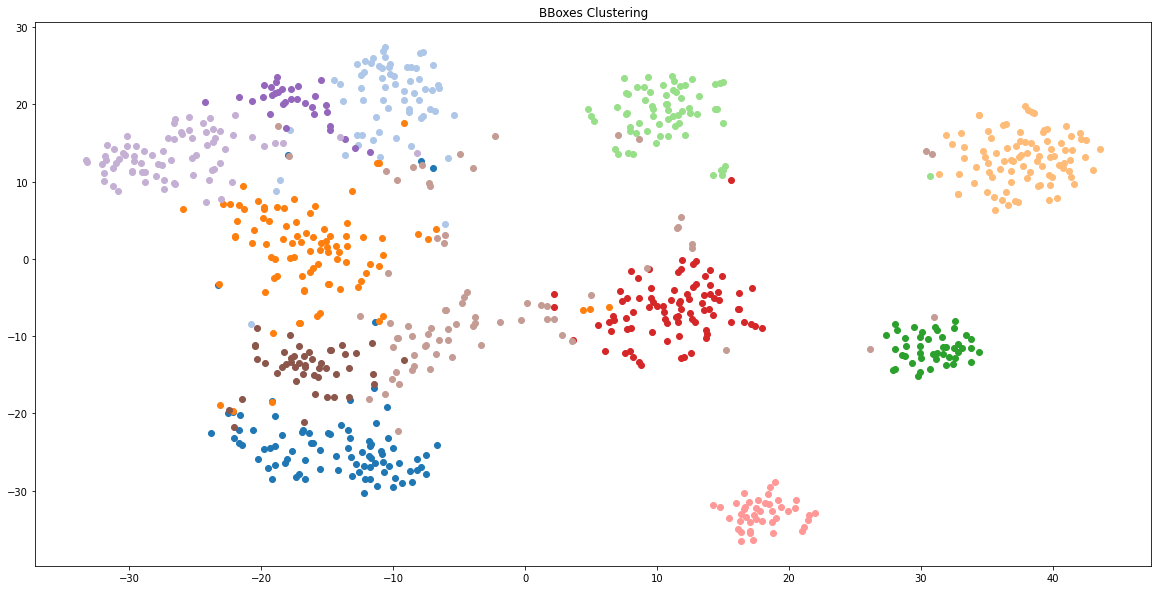

In [ ]:
#Plotting the features grouped by clusters
colors = plt.get_cmap("tab20")

plt.figure(figsize = (20,10))
plt.title('BBoxes Clustering')
for c in set(kmeans.labels_):
    indices = np.where(kmeans.labels_==c)
    plt.scatter(twod_tsne[indices,0], twod_tsne[indices, 1], color=colors(c)) 
plt.show()

In [ ]:
#Generating a dataframe with the label of each image and the cluster it belongs to 
preds = pd.DataFrame()
preds['clusters'] = kmeans.labels_
preds['label'] = labels
preds.head()

,clusters,label
0,2,0.0
1,0,0.0
2,0,0.0
3,2,0.0
4,10,0.0


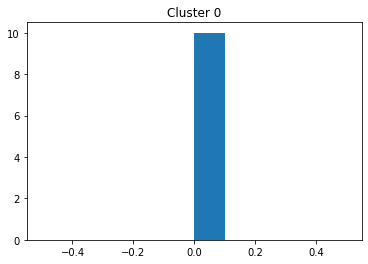

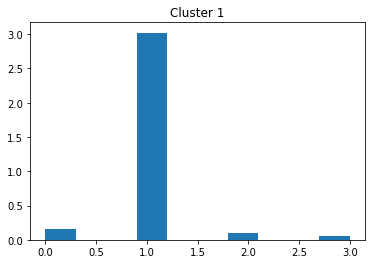

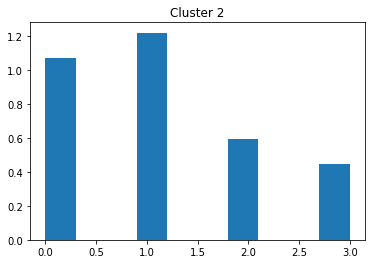

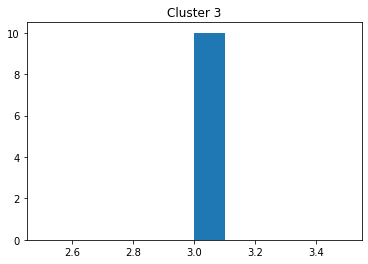

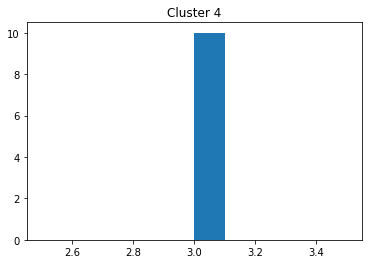

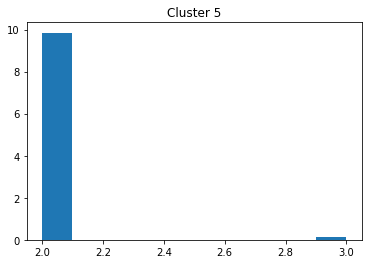

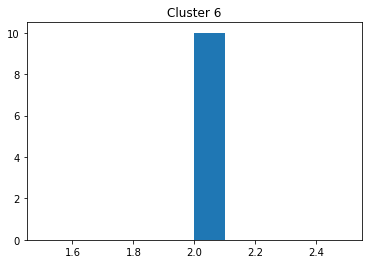

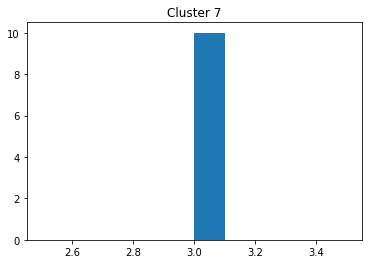

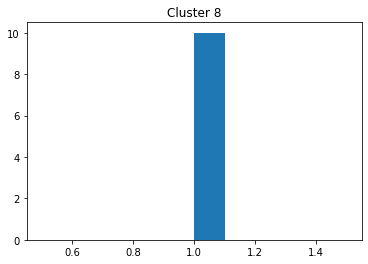

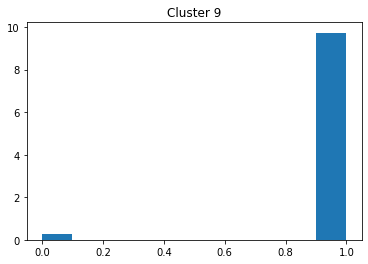

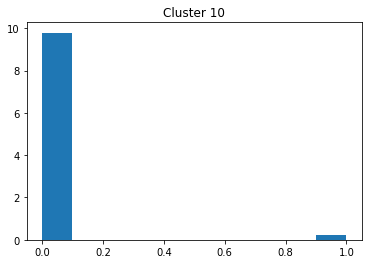

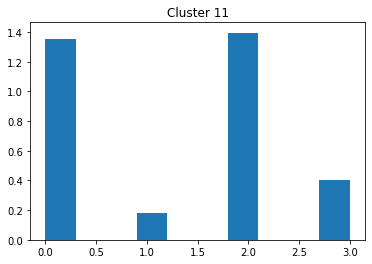

In [ ]:
#Visualizing species distribution within each identified cluster
for clust in set(preds['clusters']):
  plt.hist(preds.loc[preds['clusters'] == clust, 'label'], density = True)
  plt.title(f'Cluster {clust}')
  plt.show()

In [ ]:
preds.to_csv('/content/drive/MyDrive/family_bbcontent_predictions.csv')